## This notebook builds off of BasinStreamflow_PhysRadIndexing
Goal is to assess which basins have a roughly linear relatoinship (i.e., phys+rad+residual=full). Then for those, plot contributions of PHYS and RAD to the FULL change. 
<br><br>
**Approach**: <br>
1) Estimate the residual for each basin as the Root Mean Squared Error (RMSE) between the change in FULL from CTRL and the change in PHYS+RAD from CTRL (as a fractional change, i.e., dFull = (FULL-CTRL)/CTRL) over all thirty years assessed. <br>
2) If a basin is to be considered "linear", the sum of PHYS+RAD must be larger than the residual. Otherwise, the basin is ignored.

Basins are defined as follows: 
<font color=green>
% Key: <br>
   1.......Yukon <br>
   2.......Mackenzie<br>
   3.......Columbia<br>
   4.......Nelson<br>
   5.......Mississippi<br>
   6.......St-Lawrence<br>
   7.......Rhine<br>
   8.......Danube<br>
   9.......Dniepr<br>
   10......Volga<br>
   11......Ob<br>
   12......Yenisei<br>
   13......Lena<br>
   14......Amur<br>
   15......Orinoco<br>
   16......Parana<br>
   17......Amazonas<br>
   18......Niger<br>
   19......Congo<br>
   20......Nile<br>
   21......Zambezi<br>
   22......Tigris & Euphrates<br>
   23......Indus<br>
   24......Ganges & Brahmaputra<br>
   25......Mekong<br>
   26......Huang-he<br>
   27......Yangtze<br>
   28......Murray & Darling<br>
   29......Don<br>
   30......Fraser<br>
   31......Tocantins<br>
   32......Vuoski & Neva<br>
    </font>

In [1]:
import scipy as scipy
import scipy.io as sio
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import xarray as xr
import pickle 
import os
import copy
from netCDF4 import Dataset


<font color=purple> 
    Set up river-relevant constant arrays <br> <br> 
    Read in data and define arrays for basic use 
</font>


In [2]:
#Define list of basin names based on key (used in plotting)
basinNames = ['Yukon','Mackenzie','Columbia','Nelson','Mississippi','St-Lawrence','Rhine','Danube','Dniepr','Volga','Ob','Yenisei',\
'Lena','Amur','Orinoco','Parana','Amazonas','Niger','Congo','Nile','Zambezi','Tigris & Euphrates','Indus',\
'Ganges & Brahmaputra','Mekong','Huang-he','Yangtze','Murray & Darling','Don','Fraser','Tocantins','Vuoski & Neva']

#Define time array for plotting too
days = np.arange(365)+1

#Beginning julian days for each month
startMon = [0, 31,59, 90,120,151,181,212,243,273,304,334]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']



In [4]:
#Get dimensions from a single file (same will be used for all files)
file1 = 'fldare1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 

#Read in bsin ID identifiers from Matlab file 
basinData = sio.loadmat('BasinMask.mat')
basinMask = basinData['BasinMask']

#Read in CaMa gridcell areas
matData = sio.loadmat('CaMa_gridAreas.mat')
area    = matData['area']


In [5]:
## Read in daily streamflow data from CaMa ##

#Read indices for subsetted data 
lonFile = open("lonIndices_subsetKey.txt","r")
latFile = open("latIndices_subsetKey.txt","r")

lonSubset=[]
for line in lonFile.readlines():
    lonSubset.append(float(line))  

latSubset=[]
for line in latFile.readlines():
    latSubset.append(float(line))

#Set filepaths for daily data
ctrlFile = 'Control_outflow_subset.nc'
fullFile = 'Full_outflow_subset.nc'
physFile = 'Physiology_outflow_subset.nc'
radFile  = 'Radiation_outflow_subset.nc'

#Read in outflow data  
fCtrl = xr.open_dataset(ctrlFile,decode_times=False)
fFull = xr.open_dataset(fullFile,decode_times=False)
fPhys = xr.open_dataset(physFile,decode_times=False)
fRad  = xr.open_dataset(radFile,decode_times=False)

outflwCtrl = fCtrl.outflow
outflwFull = fFull.outflow
outflwPhys = fPhys.outflow
outflwRad  = fRad.outflow


In [6]:
## Read in monthly CESM data ##
#fileBase = '/gdata/pritchard2/mdfowler/Flooding-physiology/RelatedCESMvariables/'

# Read in rainfall and soil liquid 
fCtrl = xr.open_dataset('cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc',decode_times=False)
# fFull = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fPhys = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fRad  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)

#CESM lat and lon
cesmLon = fCtrl.lon.values
cesmLat = fCtrl.lat.values

#Read in basin mask at CESM resolution 
basinData = sio.loadmat('BasinMask_CESMres.mat')
basinMask_CESM = basinData['basinMaskNew']

#Gridcell area at CESM resolution 
cesmArea = fCtrl.area.values

## For each basin, determine changes in mean/max/min streamflow 

In [7]:
#Define empty arrays to store basin-specific data in 
annCtrl = np.full([len(basinNames),30,365],np.nan)
annFull = np.full([len(basinNames),30,365],np.nan)
annPhys = np.full([len(basinNames),30,365],np.nan)
annRad  = np.full([len(basinNames),30,365],np.nan)
avgCtrl = np.full([len(basinNames),365],np.nan)
avgFull = np.full([len(basinNames),365],np.nan)
avgPhys = np.full([len(basinNames),365],np.nan)
avgRad = np.full([len(basinNames),365],np.nan)
avgLat = np.full([len(basinNames)],np.nan)
avgLon = np.full([len(basinNames)],np.nan)
basinArea_CaMa = np.full([len(basinNames)],np.nan)

## ---- Loop over basins ---- ##

for iBasin in range(len(basinNames)):
    basinChoice = iBasin+1
    
    #Define empty arrays and variable to count number of obs in basin
    iSubset  = []
    gridArea = []
    basinObs = 0
    
    #Loop over every location in the subset of daily data 
    for iLoc in range(len(lonSubset)): 
        ilon = int(lonSubset[iLoc])
        ilat = int(latSubset[iLoc])

        if (basinMask[ilon,ilat]==basinChoice):
            iSubset = np.append(iSubset,iLoc)               #Save iLoc (index of subset) if in basin
            gridArea = np.append(gridArea,area[ilon,ilat])  #Save area of each valid gridcell   
            basinObs = basinObs+1

    iSubset=np.asarray(iSubset,dtype=int)  
    print(basinObs, ' points used in the', basinNames[basinChoice-1])

    #Isolate just the data in specified basin for further analysis 
    basinLon  = np.take(lonSubset,iSubset)
    basinLat  = np.take(latSubset,iSubset)
    basinCtrl = np.take(outflwCtrl.values,iSubset,axis=0)
    basinFull = np.take(outflwFull.values,iSubset,axis=0)
    basinPhys = np.take(outflwPhys.values,iSubset,axis=0)
    basinRad  = np.take(outflwRad.values,iSubset,axis=0)
    avgLat[iBasin] = np.nanmean(lat[np.asarray(basinLat,dtype=int)])
    avgLon[iBasin] = np.nanmean(lon[np.asarray(basinLon,dtype=int)])
    basinArea_CaMa[iBasin] = np.nansum(gridArea*1e6) #Convert from km^2 to m^2 
    print('Basin isolated')

    #-------------------------------------------------------------------------------

    ## Create annual climatology ##

    # Area weighted averages 
    wgtAvgCtrl = np.full([30*365],np.nan)
    wgtAvgFull = np.full([30*365],np.nan)
    wgtAvgPhys = np.full([30*365],np.nan)
    wgtAvgRad  = np.full([30*365],np.nan)

    for iDay in range(30*365): 
        wgtAvgCtrl[iDay] = np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea)
        wgtAvgFull[iDay] = np.nansum(gridArea*basinFull[:,iDay])/np.nansum(gridArea)
        wgtAvgPhys[iDay] = np.nansum(gridArea*basinPhys[:,iDay])/np.nansum(gridArea)
        wgtAvgRad[iDay]  = np.nansum(gridArea*basinRad[:,iDay])/np.nansum(gridArea)
    print('Area weighting completed')

    # Split into 30 years to get at composite seasonal cycle (dimensions are [30 x 365])
    annCtrl[iBasin,:,:] = np.split(wgtAvgCtrl,30)
    annFull[iBasin,:,:] = np.split(wgtAvgFull,30)
    annPhys[iBasin,:,:] = np.split(wgtAvgPhys,30)
    annRad[iBasin,:,:]  = np.split(wgtAvgRad,30)

    # Average over years ()
    avgCtrl[iBasin,:] = np.nanmean(annCtrl[iBasin,:,:],axis=0)
    avgFull[iBasin,:] = np.nanmean(annFull[iBasin,:,:],axis=0)
    avgPhys[iBasin,:] = np.nanmean(annPhys[iBasin,:,:],axis=0) 
    avgRad[iBasin,:]  = np.nanmean(annRad[iBasin,:,:], axis=0)

    print('Annual cycle computed... Done with basin')

print('**** DONE COMPUTING BASIN STATS ****')
#Only takes about a minute to run 
    

281  points used in the Yukon
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
252  points used in the Mackenzie
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
96  points used in the Columbia
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
66  points used in the Nelson
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
264  points used in the Mississippi
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
128  points used in the St-Lawrence
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
34  points used in the Rhine
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
100  points used in the Danube
Basin isolated
Area weighting completed
Annual cycle computed... Done with basin
50  points used in the Dniepr
Basin isolated
Area weighting completed
Annual cycle computed...

## Assuming that every year, dPhys+dRad+residual = dFull, what is the internal variability of that residual? 
* Use that to determine which basins are "linear" or not - if dPhys+dRad not bigger than that residual, don't assess that basin 

In [8]:
# For each basin, use all years to arrive at a measure of the residual 

#Define 30-year average mean, max, and min 
annMeanCtrl = np.nanmean(annCtrl,axis=2)
annMeanFull = np.nanmean(annFull,axis=2)
annMeanPhys = np.nanmean(annPhys,axis=2)
annMeanRad  = np.nanmean(annRad, axis=2)

# annMaxCtrl  = np.nanmax(annCtrl, axis=2)
# annMaxFull  = np.nanmax(annFull, axis=2)
# annMaxPhys  = np.nanmax(annPhys, axis=2)
# annMaxRad   = np.nanmax(annRad,  axis=2)

# annMinCtrl = np.nanmin(annCtrl, axis=2)
# annMinFull = np.nanmin(annFull, axis=2)
# annMinPhys = np.nanmin(annPhys, axis=2)
# annMinRad  = np.nanmin(annRad,  axis=2)

# --- Updated: use percentiles to define high and low flows each year --- #
annMaxCtrl = np.nanpercentile(annCtrl,95,axis=2)
annMaxFull = np.nanpercentile(annFull,95,axis=2)
annMaxPhys = np.nanpercentile(annPhys,95,axis=2)
annMaxRad  = np.nanpercentile(annRad, 95,axis=2)

annMinCtrl = np.nanpercentile(annCtrl, 5,axis=2)
annMinFull = np.nanpercentile(annFull, 5,axis=2)
annMinPhys = np.nanpercentile(annPhys, 5,axis=2)
annMinRad  = np.nanpercentile(annRad,  5,axis=2)

#Take fractional difference from CTRL for each case (FULL,PHYS,RAD)
diffMeanFull_ann = (annMeanFull-annMeanCtrl)/annMeanCtrl
diffMeanPhys_ann = (annMeanPhys-annMeanCtrl)/annMeanCtrl
diffMeanRad_ann  = (annMeanRad-annMeanCtrl)/annMeanCtrl
diffMeanSum_ann  = diffMeanPhys_ann+diffMeanRad_ann 

diffMaxFull_ann  = (annMaxFull-annMaxCtrl)/annMaxCtrl
diffMaxPhys_ann  = (annMaxPhys-annMaxCtrl)/annMaxCtrl
diffMaxRad_ann   = (annMaxRad-annMaxCtrl)/annMaxCtrl
diffMaxSum_ann   = diffMaxPhys_ann+diffMaxRad_ann

diffMinFull_ann = (annMinFull-annMinCtrl)/annMinCtrl
diffMinPhys_ann = (annMinPhys-annMinCtrl)/annMinCtrl
diffMinRad_ann  = (annMinRad-annMinCtrl)/annMinCtrl
diffMinSum_ann  = diffMinPhys_ann+diffMinRad_ann

#Compute RMSE for every basin from yearly data 
rmseMean_ann = np.full([len(basinNames)],np.nan)
rmseMax_ann  = np.full([len(basinNames)],np.nan)
rmseMin_ann  = np.full([len(basinNames)],np.nan)

for iBasin in range(len(basinNames)): 
    rmseMean_ann[iBasin] = np.sqrt(np.mean((diffMeanSum_ann[iBasin,:]-diffMeanFull_ann[iBasin,:])**2))
    rmseMax_ann[iBasin]  = np.sqrt(np.mean((diffMaxSum_ann[iBasin,:]-diffMaxFull_ann[iBasin,:])**2))
    rmseMin_ann[iBasin]  = np.sqrt(np.mean((diffMinSum_ann[iBasin,:]-diffMinFull_ann[iBasin,:])**2))
    

In [14]:
np.shape(annMeanCtrl)

(32, 30)

## Map of basin-level residuals 

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


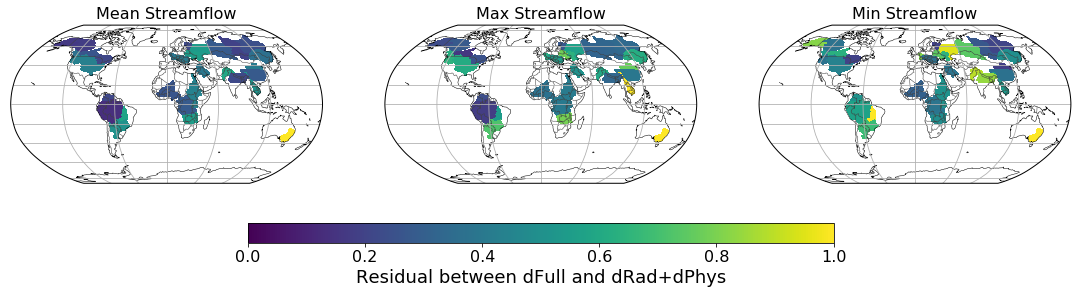

In [9]:
## Map of RMSE between sum and full for each case 

#Need to make lon/lat arrays with useful information 
# -- How about for the entire basin, use the avg pctDiff for each variable? 
globalDiffMean = np.full([len(lat),len(lon)],np.nan)
globalDiffMax  = np.full([len(lat),len(lon)],np.nan)
globalDiffMin  = np.full([len(lat),len(lon)],np.nan)
globalDiffTime = np.full([len(lat),len(lon)],np.nan)

for iBasin in range(len(basinNames)):
    basinChoice=iBasin+1
    for ilon in range(len(lon)):
        for ilat in range(len(lat)):
            if (basinMask[ilon,ilat]==basinChoice):
                globalDiffMean[ilat,ilon] = rmseMean_ann[iBasin]
                globalDiffMax[ilat,ilon]  = rmseMax_ann[iBasin]
                globalDiffMin[ilat,ilon]  = rmseMin_ann[iBasin]
                

#Set up figure window 
## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
fig.set_size_inches(19,14)

#Plot linearity for mean streamflow 
ax1.set_global()
contour_plot = ax1.pcolormesh(lon,lat,globalDiffMean,hatch='/',cmap='viridis',vmin=0,vmax=1,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('Mean Streamflow')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Plot linearity for max streamflow
ax2.set_global()
contour_plot = ax2.pcolormesh(lon,lat,globalDiffMax,cmap='viridis',vmin=0,vmax=1,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.24, ax_position.width+0.2, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Residual between dFull and dRad+dPhys',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax2.set_title('Max Streamflow')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Plot linearity for min streamflow
ax3.set_global()
contour_plot = ax3.pcolormesh(lon,lat,globalDiffMin,cmap='viridis',vmin=0,vmax=1,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('Min Streamflow')
ax3.title.set_fontsize(16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



**Make a table with information on actual changes in each category and RMSE**

In [10]:
print('------------------------------- MEAN STREAMFLOW ------------------------------- ')
print('               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE')
print('-------------------------------------------------------------------------------')
for iB in range(len(basinNames)):
    print('%2i %20s %10.2f %10.2f %10.2f %10.2f %10.2f' % (iB, basinNames[iB], np.nanmean(annMeanCtrl[iB,:]), 
                                       np.nanmean(diffMeanFull_ann[iB,:])*100,
                                       np.nanmean(diffMeanPhys_ann[iB,:])*100, 
                                       np.nanmean(diffMeanRad_ann[iB,:])*100,
                                       rmseMean_ann[iB]))
    print()
    
    
    

------------------------------- MEAN STREAMFLOW ------------------------------- 
               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE
-------------------------------------------------------------------------------
 0                Yukon    4011.96      33.68       2.66      29.81       0.17

 1            Mackenzie    3700.77      29.09      10.69      19.66       0.18

 2             Columbia    3144.51      14.65       3.87      23.02       0.43

 3               Nelson    1175.45      15.06       8.82      18.65       0.26

 4          Mississippi    2752.70      41.25      13.55      29.83       0.43

 5          St-Lawrence    3426.80       7.05      -5.77      14.86       0.21

 6                Rhine    1677.32      -0.81       8.91      -5.89       0.38

 7               Danube    2290.04     -16.58      13.04     -22.88       0.41

 8               Dniepr    1901.25      -4.89       9.56       9.26       0.55

 9                Volga    3353.25      

In [11]:
print('------------------------------- MEAN STREAMFLOW ------------------------------- ')
print('               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE')
print('-------------------------------------------------------------------------------')
for iB in range(len(basinNames)):
    print('%2i %20s %10.2f %10.2f %10.2f %10.2f %10.2f' % (iB, basinNames[iB], np.nanmean(annMaxCtrl[iB,:]), 
                                       np.nanmean(diffMaxFull_ann[iB,:])*100,
                                       np.nanmean(diffMaxPhys_ann[iB,:])*100, 
                                       np.nanmean(diffMaxRad_ann[iB,:])*100,
                                       rmseMax_ann[iB]))
    print()
    
    
    

------------------------------- MEAN STREAMFLOW ------------------------------- 
               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE
-------------------------------------------------------------------------------
 0                Yukon    7496.18       0.32       5.24      -3.64       0.23

 1            Mackenzie    6251.49       5.67      11.93      -1.87       0.28

 2             Columbia    8725.18      -3.53      10.70       4.70       0.64

 3               Nelson    1628.75      -0.42       5.09       0.63       0.16

 4          Mississippi    3822.31      58.57      23.57      49.11       0.61

 5          St-Lawrence    3775.37       9.34      -4.71      14.27       0.25

 6                Rhine    3005.07      16.87      21.09       8.50       0.61

 7               Danube    2885.41     -13.76      18.04     -21.47       0.55

 8               Dniepr    2654.52      -3.81      16.31      16.79       0.78

 9                Volga    6502.04      

In [12]:
print('------------------------------- MEAN STREAMFLOW ------------------------------- ')
print('               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE')
print('-------------------------------------------------------------------------------')
for iB in range(len(basinNames)):
    print('%2i %20s %10.2f %10.2f %10.2f %10.2f %10.2f' % (iB, basinNames[iB], np.nanmean(annMinCtrl[iB,:]), 
                                       np.nanmean(diffMinFull_ann[iB,:])*100,
                                       np.nanmean(diffMinPhys_ann[iB,:])*100, 
                                       np.nanmean(diffMinRad_ann[iB,:])*100,
                                       rmseMin_ann[iB]))
    print()
    
    
    

------------------------------- MEAN STREAMFLOW ------------------------------- 
               Basin        CTRL     dFull(%)     dPhys(%)     dRad(%)    RMSE
-------------------------------------------------------------------------------
 0                Yukon    1118.12     223.74       7.73     206.82       0.82

 1            Mackenzie    1959.35      80.97      24.02      67.06       0.38

 2             Columbia     719.92      -1.83      -0.36       3.85       0.38

 3               Nelson     710.94      57.94      28.81      67.47       0.64

 4          Mississippi    1636.28      24.25       4.11       8.81       0.44

 5          St-Lawrence    3103.41       5.60      -6.71      14.97       0.20

 6                Rhine     699.42     -13.15      12.49      -9.39       0.81

 7               Danube    1608.07     -20.42      12.03     -24.43       0.37

 8               Dniepr    1113.61       0.10      10.27      15.56       0.75

 9                Volga    1502.64      

## Defining basins as linear or non-linear 

In [11]:
np.shape(diffMeanPhys_ann)

(32, 30)

In [13]:
# Define basins to consider as valid if change in sum is greater than the residual (RMSE) 

#Average over all 30 years in a basin
avgDiffMeanPhys = np.nanmean(diffMeanPhys_ann,axis=1)
avgDiffMeanRad  = np.nanmean(diffMeanRad_ann,axis=1)
avgDiffMeanSum  = avgDiffMeanPhys + avgDiffMeanRad

avgDiffMaxPhys  = np.nanmean(diffMaxPhys_ann,axis=1)
avgDiffMaxRad   = np.nanmean(diffMaxRad_ann,axis=1)
avgDiffMaxSum   = avgDiffMaxPhys + avgDiffMaxRad

avgDiffMinPhys  = np.nanmean(diffMinPhys_ann,axis=1)
avgDiffMinRad   = np.nanmean(diffMinRad_ann,axis=1)
avgDiffMinSum   = avgDiffMinPhys + avgDiffMinRad

allValidMean = np.where( np.abs(avgDiffMeanSum)>rmseMean_ann )
allValidMax  = np.where( np.abs(avgDiffMaxSum)>rmseMax_ann ) 
allValidMin  = np.where( np.abs(avgDiffMinSum)>rmseMin_ann )

allValid     = np.where( (np.abs(avgDiffMeanSum)>rmseMean_ann) | 
                         (np.abs(avgDiffMaxSum)>rmseMax_ann) |
                         (np.abs(avgDiffMinSum)>rmseMin_ann))


print('Basins where mean is valid:',allValidMean)
print('Basins where max is valid: ',allValidMax)
print('Basins where min is valid: ',allValidMin)
print('Number of basins with at least one metric valid: ',np.shape(allValid))

Basins where mean is valid: (array([ 0,  1,  3,  4,  9, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 26]),)
Basins where max is valid:  (array([ 4, 13, 14, 15, 16, 18, 19, 23, 24, 26]),)
Basins where min is valid:  (array([ 0,  1,  3,  9, 10, 11, 12, 13, 15, 18, 19, 21, 24, 26]),)
Number of basins with at least one metric valid:  (1, 18)


In [14]:
#Compute PHYS or RAD contribution (as dPhys or dRad /dFull) only for basins where linearity roughly holds 

meanFull = np.nanmean(diffMeanFull_ann,axis=1)
maxFull  = np.nanmean(diffMaxFull_ann, axis=1)
minFull  = np.nanmean(diffMinFull_ann, axis=1)

physMeanInd = avgDiffMeanPhys/meanFull
physMaxInd  = avgDiffMaxPhys/maxFull
physMinInd  = avgDiffMinPhys/minFull

radMeanInd  = avgDiffMeanRad/meanFull
radMaxInd   = avgDiffMaxRad/maxFull
radMinInd   = avgDiffMinRad/minFull 


## Plotting adventures 
* Bars to represent change in PHYS/RAD and a star for the FULL change? (Baird's idea) 
* Circles of varying diameters to represnt changes? (Mike's idea)
* Bar plots (Chris) 
* Just the usual maps? (Chris) 

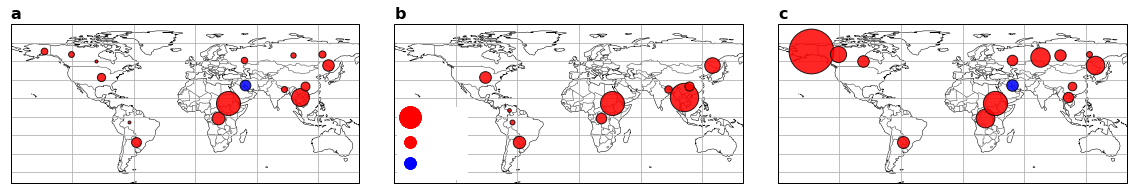

In [15]:

#Set up figure window 
## --- Set up figure window --- 
fig = plt.figure() 
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())

# fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.PlateCarree()})
# ax1,ax2,ax3 = ax_array.flatten()
fig.set_size_inches(20,12)
ax1.set_extent([-180,160,-65,90], crs=ccrs.PlateCarree())
ax2.set_extent([-180,160,-65,90], crs=ccrs.PlateCarree())
ax3.set_extent([-180,160,-65,90], crs=ccrs.PlateCarree())
# ax1.set_global()
# ax2.set_global()
# ax3.set_global()

#Set up backgrounds
#ax1.set_title('Change in Mean Streamflow')
ax1.set_title('a',{'fontweight' :'bold','fontsize':16},loc='left') 
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#ax2.set_title('Change in Max Streamflow')
ax2.set_title('b',{'fontweight' :'bold','fontsize':16},loc='left') 
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#ax3.set_title('Change in Min Streamflow')
ax3.set_title('c',{'fontweight' :'bold','fontsize':16},loc='left') 
ax3.title.set_fontsize(16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


for iBasin in range(np.size(allValidMean)):
    #Index of basin 
    basinChoice = allValidMean[0][iBasin]
    #Define fractional increase from CTRL in experiments 
    diffFull  = np.nanmean(diffMeanFull_ann[basinChoice,:])   
    ax1.plot(avgLon[basinChoice],avgLat[basinChoice],color='Red',linestyle='none',markeredgecolor='black',marker='o',markersize=(diffFull*20),alpha=0.85)
    if diffFull<0:
        ax1.plot(avgLon[basinChoice],avgLat[basinChoice],color='Blue',linestyle='none',markeredgecolor='black',marker='o',markersize=(abs(diffFull)*20),alpha=0.85)


for iBasin in range(np.size(allValidMax)):
    #Index of basin 
    basinChoice = allValidMax[0][iBasin]
    #Define fractional increase from CTRL in experiments 
    diffFull  = np.nanmean(diffMaxFull_ann[basinChoice,:])   
    ax2.plot(avgLon[basinChoice],avgLat[basinChoice],color='Red',linestyle='none',markeredgecolor='black',marker='o',markersize=(diffFull*20),alpha=0.85)
    if diffFull<0:
        ax2.plot(avgLon[basinChoice],avgLat[basinChoice],color='Blue',linestyle='none',markeredgecolor='black',marker='o',markersize=(abs(diffFull)*20),alpha=0.85)
    
    #Add reference circle 
#     rect = patches.Rectangle((-175,-65),90,70,linewidth=2, facecolor='white',edgecolor='black', transform=ccrs.PlateCarree())    #SE US
#     ax2.add_patch(rect)
    ax2.text(0.02,0.05,'   ', va='bottom', ha='left',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax2.transAxes,fontsize=65,bbox=dict(facecolor='white',edgecolor='white', alpha=0.75))
    
    ax2.plot(-165,0,color='red',linestyle='none',markeredgewidth=2,marker='o',markersize=(1*20), zorder=5)
    ax2.plot(-165,-25,color='red',linestyle='none',markeredgewidth=2,marker='o',markersize=(0.5*20),zorder=5)
    ax2.plot(-165,-45,color='blue',linestyle='none',markeredgewidth=2,marker='o',markersize=(0.5*20),zorder=5)


for iBasin in range(np.size(allValidMin)):
    #Index of basin 
    basinChoice = allValidMin[0][iBasin]
    #Define fractional increase from CTRL in experiments 
    diffFull  = np.nanmean(diffMinFull_ann[basinChoice,:])   
    ax3.plot(avgLon[basinChoice],avgLat[basinChoice],color='Red',linestyle='none',markeredgecolor='black',marker='o',markersize=(diffFull*20),alpha=0.85)
    if diffFull<0:
        ax3.plot(avgLon[basinChoice],avgLat[basinChoice],color='Blue',linestyle='none',markeredgecolor='black',marker='o',markersize=(abs(diffFull)*20),alpha=0.85)

        
    
fig.subplots_adjust(wspace=0.1, hspace=0.2)

#fig.savefig('MapCircles_StreamflowChange_V2.eps',bbox_inches = 'tight')  #Save figure as pdf




<font color=purple> 
    Bottom panels <br> 
</font>



In [16]:
#Define percent changes for mean streamflows 
meanFull = np.nanmean(diffMeanFull_ann,axis=1)*100
meanPhys = np.nanmean(diffMeanPhys_ann,axis=1)*100
meanRad  = np.nanmean(diffMeanRad_ann,axis=1)*100
meanSum  = meanPhys+meanRad

#Define percent changes for max streamflows 
maxFull = np.nanmean(diffMaxFull_ann,axis=1)*100
maxPhys = np.nanmean(diffMaxPhys_ann,axis=1)*100
maxRad  = np.nanmean(diffMaxRad_ann,axis=1)*100
maxSum  = maxPhys+maxRad

#Define percent changes for min streamflows 
minFull = np.nanmean(diffMinFull_ann,axis=1)*100
minPhys = np.nanmean(diffMinPhys_ann,axis=1)*100
minRad  = np.nanmean(diffMinRad_ann,axis=1)*100
minSum  = minPhys+minRad


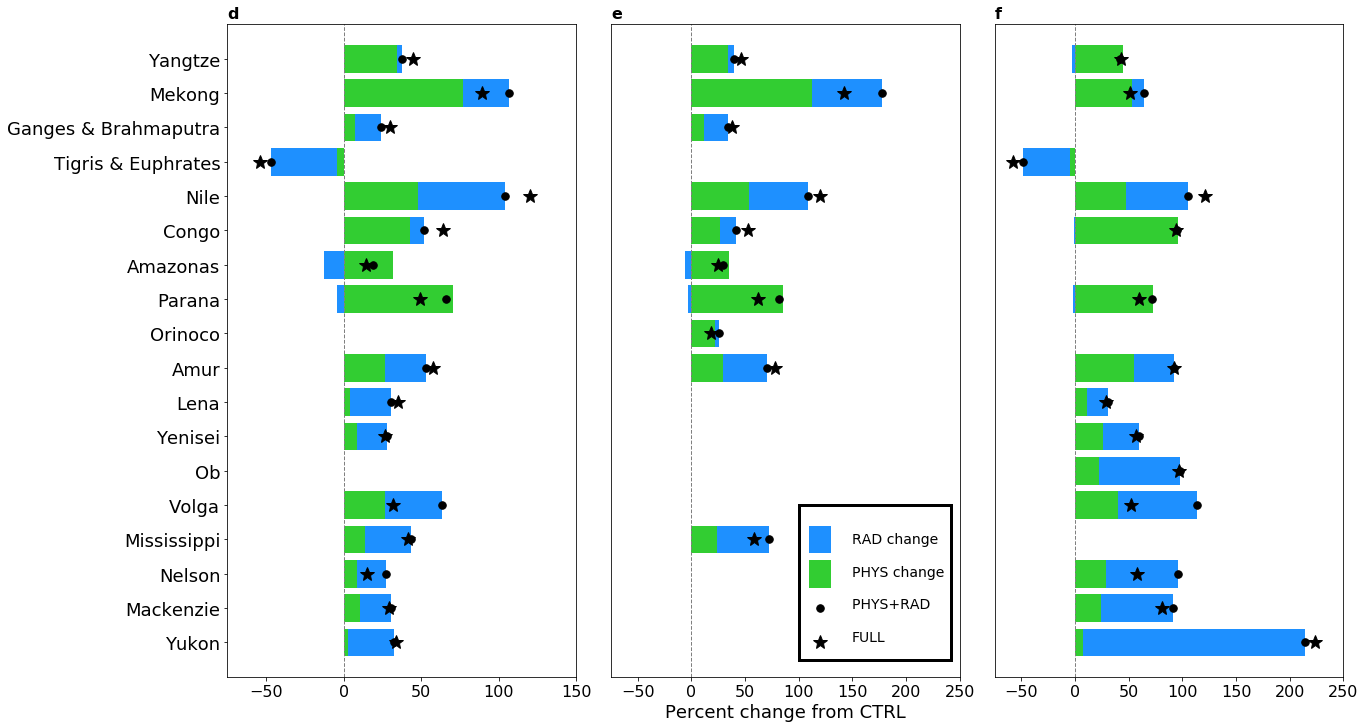

In [18]:
# Can we combine all three into one single plot? 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3)
ax1,ax2,ax3 = ax_array.flatten()
fig.set_size_inches(20,12)

fig.subplots_adjust(wspace=0.1, hspace=0.2)

#Set up axes 
# ax1.set_title('Change in Mean Streamflow',fontsize=18)
# ax2.set_title('Change in Max Streamflow',fontsize=18)
# ax3.set_title('Change in Min Streamflow',fontsize=18)
ax1.set_title('d',{'fontweight' :'bold','fontsize':16},loc='left') 
ax2.set_title('e',{'fontweight' :'bold','fontsize':16},loc='left') 
ax3.set_title('f',{'fontweight' :'bold','fontsize':16},loc='left') 

ax1.set_xlim(-75,150)
ax2.set_xlim(-75,250)
ax3.set_xlim(-75,250)
ax2.set_xlabel('Percent change from CTRL',fontsize=18)
ax1.tick_params(axis='x',labelsize=16)
ax2.tick_params(axis='x',labelsize=16)
ax3.tick_params(axis='x',labelsize=16)


ax1.set_yticks(np.arange(np.size(allValid)))
ax2.set_yticks(np.arange(np.size(allValid)))
ax3.set_yticks(np.arange(np.size(allValid)))
ax1.set_yticklabels(np.array(basinNames)[allValid],fontsize=18)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax1.set_ylim(-1,np.size(allValid))
ax2.set_ylim(-1,np.size(allValid))
ax3.set_ylim(-1,np.size(allValid))

ax1.axvline(linewidth=1,color='gray',linestyle='dashed')
ax2.axvline(linewidth=1,color='gray',linestyle='dashed')
ax3.axvline(linewidth=1,color='gray',linestyle='dashed')


#Work on first subplot: MEAN STREAMFLOW 
for iBasin in range(np.size(allValidMean)):
    #Index of basin 
    basinChoice = np.where(allValid == allValidMean[0][iBasin])
    basinChoice = np.array(basinChoice)[1,0]
        
    ax1.plot(meanFull[allValid[0][basinChoice]],basinChoice, color='black', marker='*',markersize=15)
    ax1.plot(meanSum[allValid[0][basinChoice]],basinChoice,color='black',marker='.',markersize=15)
    
    if ((meanPhys[allValid[0][basinChoice]]<0) & (meanRad[allValid[0][basinChoice]]>0)): 
        ax1.barh(basinChoice,meanPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax1.barh(basinChoice,meanRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    elif ((meanPhys[allValid[0][basinChoice]]>0) & (meanRad[allValid[0][basinChoice]]<0)): 
        ax1.barh(basinChoice,meanPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax1.barh(basinChoice,meanRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    else: 
        ax1.barh(basinChoice,meanPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax1.barh(basinChoice,meanRad[allValid[0][basinChoice]],left=meanPhys[allValid[0][basinChoice]],color='DodgerBlue')


#Work on second subplot: MAX STREAMFLOW 
for iBasin in range(np.size(allValidMax)): 
    #Index of basin 
    basinChoice = np.where(allValid == allValidMax[0][iBasin])
    basinChoice = np.array(basinChoice)[1,0]

    ax2.plot(maxFull[allValid[0][basinChoice]],basinChoice, color='black', marker='*',markersize=15)
    ax2.plot(maxSum[allValid[0][basinChoice]],basinChoice,color='black',marker='.',markersize=15)

    if ((maxPhys[allValid[0][basinChoice]]<0) & (maxRad[allValid[0][basinChoice]]>0)): 
        ax2.barh(basinChoice,maxPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax2.barh(basinChoice,maxRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    elif ((maxPhys[allValid[0][basinChoice]]>0) & (maxRad[allValid[0][basinChoice]]<0)): 
        ax2.barh(basinChoice,maxPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax2.barh(basinChoice,maxRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    else: 
        ax2.barh(basinChoice,maxPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax2.barh(basinChoice,maxRad[allValid[0][basinChoice]],left=maxPhys[allValid[0][basinChoice]],color='DodgerBlue')
#Plot legend in second plot at bottom 
ax2.plot(120,0, color='black', marker='*',markersize=15)
ax2.plot(120,1,color='black', marker='.',markersize=15)
ax2.barh(2,20,left=110,color='LimeGreen')
ax2.barh(3,20,left=110,color='DodgerBlue')
rect = patches.Rectangle((100,-0.5),142,4.5,linewidth=3,edgecolor='black',facecolor='none')
ax2.add_patch(rect)

ax2.text(0.69,0.05, 'FULL',va='bottom', ha='left',
    rotation='horizontal', rotation_mode='anchor',
    transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='white',edgecolor='white', alpha=0.75))
ax2.text(0.69,0.10, 'PHYS+RAD ',va='bottom', ha='left',
    rotation='horizontal', rotation_mode='anchor',
    transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='white',edgecolor='white', alpha=0.75))
ax2.text(0.69,0.15, 'PHYS change',va='bottom', ha='left',
    rotation='horizontal', rotation_mode='anchor',
    transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='white',edgecolor='white', alpha=0.75))
ax2.text(0.69,0.20, 'RAD change',va='bottom', ha='left',
    rotation='horizontal', rotation_mode='anchor',
    transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='white',edgecolor='white', alpha=0.75))


    
#Work on third subplot: MIN STREAMFLOW 
for iBasin in range(np.size(allValidMin)): 
    #Index of basin 
    basinChoice = np.where(allValid == allValidMin[0][iBasin])
    basinChoice = np.array(basinChoice)[1,0]

    ax3.plot(minFull[allValid[0][basinChoice]],basinChoice, color='black', marker='*',markersize=15)
    ax3.plot(minSum[allValid[0][basinChoice]],basinChoice,color='black',marker='.',markersize=15)
    
    if ((minPhys[allValid[0][basinChoice]]<0) & (minRad[allValid[0][basinChoice]]>0)): 
        ax3.barh(basinChoice,minPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax3.barh(basinChoice,minRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    elif ((minPhys[allValid[0][basinChoice]]>0) & (minRad[allValid[0][basinChoice]]<0)): 
        ax3.barh(basinChoice,minPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax3.barh(basinChoice,minRad[allValid[0][basinChoice]],left=0,color='DodgerBlue')
    else: 
        ax3.barh(basinChoice,minPhys[allValid[0][basinChoice]],left=0,color='LimeGreen')
        ax3.barh(basinChoice,minRad[allValid[0][basinChoice]],left=minPhys[allValid[0][basinChoice]],color='DodgerBlue')


#fig.savefig('BarChart_StreamflowChange.eps',bbox_inches = 'tight')  #Save figure as pdf

